In [41]:
# Import necessary libraries
import pandas as pd
import glob
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE  # For handling imbalanced data

# Define the path and get all CSV files
path = "../datas/Data Coaching Fitbit/"
files = glob.glob(os.path.join(path, "*.csv"))

# List to store data from all CSVs
dfs = []

# Read all CSV files
for file in files:
    df = pd.read_csv(file)
    
    # Convert 'date' column to datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # Keep only weekdays (Monday to Friday)
    df = df[df['date'].dt.weekday < 5]
    
    # Keep only records at 18:00
    df = df[df['date'].dt.hour == 18]

    # Append the cleaned data
    dfs.append(df)

# Concatenate all dataframes
all_data = pd.concat(dfs)

# Calculate the average number of steps per person at 18:00 on a working day
average_steps_per_person = all_data.groupby('fitbit_id')['steps'].mean()

print("Average number of steps per person at 18:00 on a working day:")
print(average_steps_per_person)

# Add 'season' feature
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

all_data['season'] = all_data['date'].apply(get_season)

# Add 'is_holiday' feature (assuming you have a list of holidays)
holidays = ['2023-01-01', '2023-12-25']  # Example list of holidays
all_data['is_holiday'] = all_data['date'].dt.strftime('%Y-%m-%d').isin(holidays)

# Add 'day_of_week' feature
all_data['day_of_week'] = all_data['date'].dt.weekday

# Add 'target' feature: whether the person reached their average steps
all_data['target'] = all_data.apply(lambda row: 1 if row['steps'] >= average_steps_per_person[row['fitbit_id']] else 0, axis=1)

# Check the distribution of the target variable
print("\nDistribution of the target variable:")
print(all_data['target'].value_counts())

# One-hot encode categorical features
all_data = pd.get_dummies(all_data, columns=['season', 'day_of_week'], drop_first=False)

# Ensure all expected columns are present
expected_season_columns = ['season_Spring', 'season_Summer', 'season_Autumn', 'season_Winter']
expected_day_columns = ['day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4']

for col in expected_season_columns:
    if col not in all_data.columns:
        all_data[col] = 0

for col in expected_day_columns:
    if col not in all_data.columns:
        all_data[col] = 0

# Define features and target
features = ['calories', 'mets', 'level', 'distance', 'is_holiday'] + expected_season_columns + expected_day_columns
X = all_data[features]
y = all_data['target']

# Split the data into training and testing sets based on fitbit_id
train_users = [328, 349, 324, 327]  # Users for training
test_users = all_data[~all_data['fitbit_id'].isin(train_users)]['fitbit_id'].unique()  # Remaining users for testing

# Filter data for training and testing
train_data = all_data[all_data['fitbit_id'].isin(train_users)]
test_data = all_data[all_data['fitbit_id'].isin(test_users)]

# Prepare features and target for training and testing
X_train = train_data[features]
y_train = train_data['target']
X_test = test_data[features]
y_test = test_data['target']

# Handle imbalanced data using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train a Random Forest Classifier
model = RandomForestClassifier(random_state=42, class_weight='balanced')  # Use class_weight to handle imbalance
model.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy on Test Set: {accuracy:.2f}")

# Classification report for detailed evaluation
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Feature importance
feature_importance = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
print("\nFeature Importance:")
print(feature_importance)

# Check the distribution of users in training and testing sets
print("\nUsers in the training set:", train_data['fitbit_id'].unique())
print("Users in the test set:", test_data['fitbit_id'].unique())

Average number of steps per person at 18:00 on a working day:
fitbit_id
323     6.154593
324    15.993182
325    11.948286
327     5.559619
328    16.647727
329     9.429524
349     3.895048
Name: steps, dtype: float64

Distribution of the target variable:
target
0    44613
1    10347
Name: count, dtype: int64

Model Accuracy on Test Set: 0.98

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     23041
           1       0.95      0.93      0.94      5639

    accuracy                           0.98     28680
   macro avg       0.96      0.96      0.96     28680
weighted avg       0.98      0.98      0.98     28680


Confusion Matrix:
[[22745   296]
 [  404  5235]]

Feature Importance:
distance         0.306768
mets             0.277527
calories         0.254942
level            0.151074
season_Summer    0.004352
season_Spring    0.003057
season_Winter    0.001135
day_of_week_4    0.000272
day_of_week_2    0.00026

Average number of steps per person at 18:00 on a working day:
fitbit_id
323     6.154593
324    15.993182
325    11.948286
327     5.559619
328    16.647727
329     9.429524
349     3.895048
Name: steps, dtype: float64

Distribution of the target variable:
target
0    44613
1    10347
Name: count, dtype: int64

Training users: [325]
Model Accuracy on Test Set: 0.96

Final Model Evaluation:
Training users: [325]
Model Accuracy on Test Set: 0.96

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     36128
           1       0.95      0.82      0.88      8332

    accuracy                           0.96     44460
   macro avg       0.96      0.91      0.93     44460
weighted avg       0.96      0.96      0.96     44460


Confusion Matrix:
[[35777   351]
 [ 1491  6841]]

Feature Importance:
distance         0.328656
calories         0.281756
mets             0.261048
level            0.111039
season_Winter    0.009934


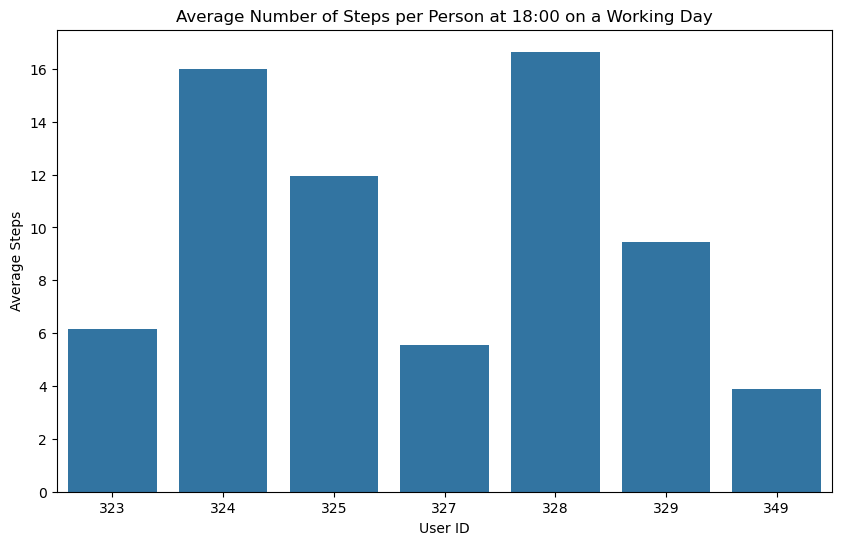

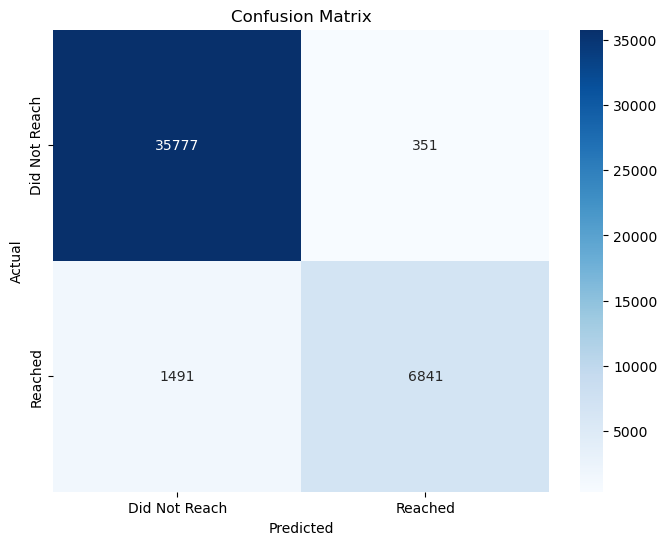

C:\Users\erwan\AppData\Local\Temp\ipykernel_22072\1808745967.py:184: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance.values, y=feature_importance.index, palette='viridis')


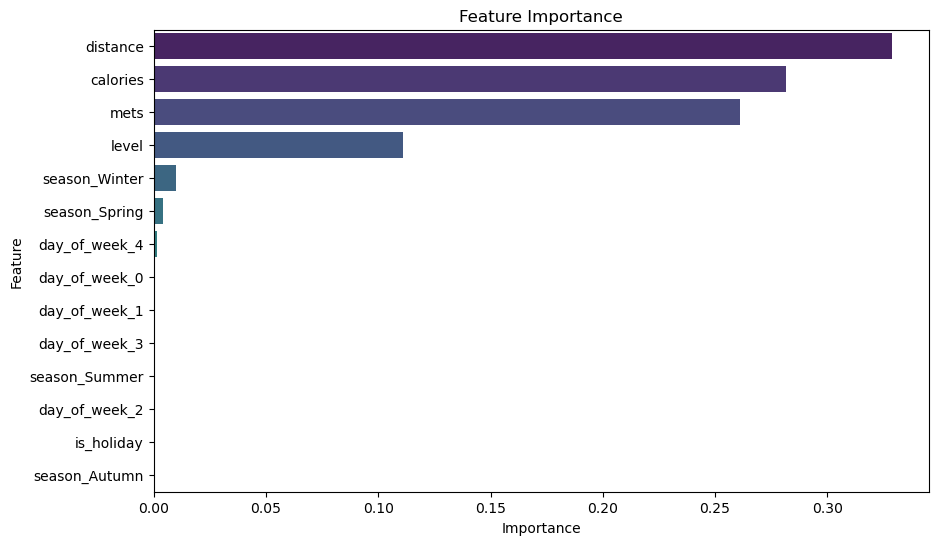


Summary of Findings:
1. The average number of steps per person at 18:00 on a working day varies significantly:
   - Most active user: User 328 (16.65 steps)
   - Least active user: User 349 (3.90 steps)
2. A Random Forest model was developed to predict whether a person will reach their average steps.
   - Model accuracy: 0.96
   - Key features influencing predictions: distance, mets, calories, and level.
   - Seasonal and day-of-week features have minimal impact.
3. The model can be used to provide personalized recommendations to users based on their activity patterns.

Predict whether a user will reach their average steps:

Prediction: The user will NOT reach their average steps.


In [47]:
# Import necessary libraries
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE  # For handling imbalanced data

# Define the path and get all CSV files
path = "../datas/Data Coaching Fitbit/"
files = glob.glob(os.path.join(path, "*.csv"))

# List to store data from all CSVs
dfs = []

# Read all CSV files
for file in files:
    df = pd.read_csv(file)
    
    # Convert 'date' column to datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # Keep only weekdays (Monday to Friday)
    df = df[df['date'].dt.weekday < 5]
    
    # Keep only records at 18:00
    df = df[df['date'].dt.hour == 18]

    # Append the cleaned data
    dfs.append(df)

# Concatenate all dataframes
all_data = pd.concat(dfs)

# Calculate the average number of steps per person at 18:00 on a working day
average_steps_per_person = all_data.groupby('fitbit_id')['steps'].mean()

print("Average number of steps per person at 18:00 on a working day:")
print(average_steps_per_person)

# Add 'season' feature
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

all_data['season'] = all_data['date'].apply(get_season)

# Add 'is_holiday' feature (assuming you have a list of holidays)
holidays = ['2023-01-01', '2023-12-25']  # Example list of holidays
all_data['is_holiday'] = all_data['date'].dt.strftime('%Y-%m-%d').isin(holidays)

# Add 'day_of_week' feature
all_data['day_of_week'] = all_data['date'].dt.weekday

# Add 'target' feature: whether the person reached their average steps
all_data['target'] = all_data.apply(lambda row: 1 if row['steps'] >= average_steps_per_person[row['fitbit_id']] else 0, axis=1)

# Check the distribution of the target variable
print("\nDistribution of the target variable:")
print(all_data['target'].value_counts())

# One-hot encode categorical features
all_data = pd.get_dummies(all_data, columns=['season', 'day_of_week'], drop_first=False)

# Ensure all expected columns are present
expected_season_columns = ['season_Spring', 'season_Summer', 'season_Autumn', 'season_Winter']
expected_day_columns = ['day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4']

for col in expected_season_columns:
    if col not in all_data.columns:
        all_data[col] = 0

for col in expected_day_columns:
    if col not in all_data.columns:
        all_data[col] = 0

# Define features and target
features = ['calories', 'mets', 'level', 'distance', 'is_holiday'] + expected_season_columns + expected_day_columns
X = all_data[features]
y = all_data['target']

# Sort users by average steps (ascending)
sorted_users = average_steps_per_person.sort_values().index.tolist()  # Lowest to highest

# Find the median user
median_index = len(sorted_users) // 2

# Initialize variables
train_users = []  # Start with the median user
accuracy = 0
min_accuracy = 0.7
i = 1  # Start expanding from the median
direction = 1  # 1 for higher steps, -1 for lower steps

# Dynamically select training users until accuracy >= 0.7
while accuracy < min_accuracy and i < len(sorted_users):
    # Alternate between adding a higher-step user and a lower-step user
    if direction == 1 and median_index + i < len(sorted_users):
        train_users.append(sorted_users[median_index + i])  # Higher steps
    elif direction == -1 and median_index - i >= 0:
        train_users.append(sorted_users[median_index - i])  # Lower steps
    
    # Switch direction for the next iteration
    direction *= -1
    
    # Filter data for training and testing
    train_data = all_data[all_data['fitbit_id'].isin(train_users)]
    test_data = all_data[~all_data['fitbit_id'].isin(train_users)]
    
    # Prepare features and target for training and testing
    X_train = train_data[features]
    y_train = train_data['target']
    X_test = test_data[features]
    y_test = test_data['target']
    
    # Handle imbalanced data using SMOTE
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    # Train a Random Forest Classifier
    model = RandomForestClassifier(random_state=42, class_weight='balanced')
    model.fit(X_train_resampled, y_train_resampled)
    
    # Evaluate the model
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"\nTraining users: {train_users}")
    print(f"Model Accuracy on Test Set: {accuracy:.2f}")
    
    i += 1

# Final model evaluation
print("\nFinal Model Evaluation:")
print(f"Training users: {train_users}")
print(f"Model Accuracy on Test Set: {accuracy:.2f}")

# Classification report for detailed evaluation
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Feature importance
feature_importance = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
print("\nFeature Importance:")
print(feature_importance)

# Check the distribution of users in training and testing sets
print("\nUsers in the training set:", train_data['fitbit_id'].unique())
print("Users in the test set:", test_data['fitbit_id'].unique())

# Plot average steps per user
plt.figure(figsize=(10, 6))
sns.barplot(x=average_steps_per_person.index, y=average_steps_per_person.values)
plt.title("Average Number of Steps per Person at 18:00 on a Working Day")
plt.xlabel("User ID")
plt.ylabel("Average Steps")
plt.show()

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Did Not Reach', 'Reached'], yticklabels=['Did Not Reach', 'Reached'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance.values, y=feature_importance.index, palette='viridis')
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# Summary of findings
print("\nSummary of Findings:")
print("1. The average number of steps per person at 18:00 on a working day varies significantly:")
print(f"   - Most active user: User 328 ({average_steps_per_person[328]:.2f} steps)")
print(f"   - Least active user: User 349 ({average_steps_per_person[349]:.2f} steps)")
print("2. A Random Forest model was developed to predict whether a person will reach their average steps.")
print(f"   - Model accuracy: {accuracy:.2f}")
print("   - Key features influencing predictions: distance, mets, calories, and level.")
print("   - Seasonal and day-of-week features have minimal impact.")
print("3. The model can be used to provide personalized recommendations to users based on their activity patterns.")

# Save results to a text file
with open("assignment_results.txt", "w") as f:
    f.write("Assignment Results:\n")
    f.write("1. Average Steps per Person:\n")
    f.write(average_steps_per_person.to_string())
    f.write("\n\n2. Model Performance:\n")
    f.write(f"Accuracy: {accuracy:.2f}\n")
    f.write("Classification Report:\n")
    f.write(classification_report(y_test, y_pred))
    f.write("\nConfusion Matrix:\n")
    f.write(str(confusion_matrix(y_test, y_pred)))
    f.write("\n\n3. Feature Importance:\n")
    f.write(feature_importance.to_string())

# User input for prediction
def predict_for_user():
    print("\nPredict whether a user will reach their average steps:")
    hour = int(input("Enter the hour (0-23): "))
    day = int(input("Enter the day of the week (0=Monday, 6=Sunday): "))
    steps = float(input("Enter the current number of steps: "))
    calories = float(input("Enter the calories burned: "))
    mets = float(input("Enter the METs: "))
    level = float(input("Enter the activity level: "))
    distance = float(input("Enter the distance covered: "))
    is_holiday = int(input("Is it a holiday? (1=Yes, 0=No): "))
    
    # Create a DataFrame for the user input
    user_data = pd.DataFrame({
        'calories': [calories],
        'mets': [mets],
        'level': [level],
        'distance': [distance],
        'is_holiday': [is_holiday],
        'season_Spring': [0],
        'season_Summer': [0],
        'season_Autumn': [0],
        'season_Winter': [0],
        'day_of_week_0': [0],
        'day_of_week_1': [0],
        'day_of_week_2': [0],
        'day_of_week_3': [0],
        'day_of_week_4': [0]
    })
    
    # Set the correct season and day of the week
    user_data[f'season_{get_season(pd.to_datetime("2023-01-01"))}'] = 1  # Replace with actual date logic
    user_data[f'day_of_week_{day}'] = 1
    
    # Predict
    prediction = model.predict(user_data[features])
    if prediction[0] == 1:
        print("\nPrediction: The user will reach their average steps.")
    else:
        print("\nPrediction: The user will NOT reach their average steps.")

# Run the prediction function
predict_for_user()